In [1]:
#Random forest: https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56

In [2]:
!pip install imblearn==0.0

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.metrics import recall_score
from imblearn.over_sampling import SMOTE

In [4]:
#the file that contains all issues and all fields
allBounty = pd.read_csv("dataset/gitcoin_dataset_5.csv")

#the file that contains fields from 'activities' array e.g. activity_type, duration_create_to_done
activity_coll = pd.read_csv("dataset/activities_collection_3.csv")

#the file that contains '# of times bounty increased' from 'activities' array
bounty_changed = pd.read_csv("dataset/changedBounty2.csv")

In [5]:
#Cleansing data

activity_coll.drop('duration_worker_applied_to_worker_approved',axis='columns', inplace=True)

#fill-in 'numerical values' with their median
allBounty['value_in_eth'].fillna(float(allBounty['value_in_eth'].median()), inplace = True)
allBounty['value_in_usdt_now'].fillna(float(allBounty['value_in_usdt_now'].median()), inplace = True)
allBounty['value_in_usdt'].fillna(float(allBounty['value_in_usdt'].median()), inplace = True)
allBounty['token_value_in_usdt'].fillna(float(allBounty['token_value_in_usdt'].median()), inplace = True)

#fill-in 'categorical values' with "NA" (except for github_issue_number)
allBounty['title'].fillna("NA", inplace = True)
allBounty['funder_last_messaged_on'].fillna("NA", inplace = True)
allBounty['is_reserved'].fillna("NA", inplace = True)
allBounty['canceled_bounty_reason'].fillna("NA", inplace = True)
allBounty['reserved_for_user_handle'].fillna("NA", inplace = True)
allBounty['attached_job_description'].fillna("NA", inplace = True)
allBounty['canceled_on'].fillna("NA", inplace = True)
allBounty['funding_organisation'].fillna("NA", inplace = True)
allBounty['featuring_date'].fillna("NA", inplace = True)
allBounty['fulfillment_accepted_on'].fillna("NA", inplace = True)
allBounty['fulfillment_submitted_on'].fillna("NA", inplace = True)
allBounty['fulfillment_started_on'].fillna("NA", inplace = True)
allBounty['keywords'].fillna("NA", inplace = True)
allBounty['bounty_owner_name'].fillna("NA", inplace = True)
allBounty['github_issue_state'].fillna("NA", inplace = True)
allBounty['bounty_owner_github_username'].fillna("NA", inplace = True)
allBounty['bounty_owner_email'].fillna("NA", inplace = True)
allBounty['github_issue_number'].fillna(0, inplace = True)
allBounty['github_repo_name'].fillna("NA", inplace = True)
allBounty['org_name'].fillna("NA", inplace = True)
allBounty['github_org_name'].fillna("NA", inplace = True)

allBounty.loc[allBounty['bounty_type'] == "0", 'bounty_type'] = "Other"
allBounty.loc[allBounty['bounty_type'] == "Andere", 'bounty_type'] = "Other"
allBounty.loc[allBounty['bounty_type'] == "Funkcja", 'bounty_type'] = "Other"
allBounty.loc[allBounty['bounty_type'] == "æ¹å", 'bounty_type'] = "Other"
allBounty['bounty_type'].fillna("NA", inplace = True)

allBounty.loc[allBounty['experience_level'] == "0", 'experience_level'] = "Other"
allBounty.loc[allBounty['experience_level'] == "Mittlere", 'experience_level'] = "Intermediate"
allBounty.loc[allBounty['experience_level'] == "åå¿è", 'experience_level'] = "Other"
allBounty.loc[allBounty['experience_level'] == "Pośredni", 'experience_level'] = "Intermediate"
allBounty['experience_level'].fillna("NA", inplace = True)

allBounty.loc[allBounty['project_length'] == "0", 'project_length'] = "Unknown"
allBounty.loc[allBounty['project_length'] == "Tage", 'project_length'] = "Days"
allBounty.loc[allBounty['project_length'] == "Miesięcy", 'project_length'] = "Months"
allBounty['project_length'].fillna("NA", inplace = True)

In [6]:
#merge two dataframe together
outer_merged = pd.merge(allBounty, activity_coll, how="outer", on=["pk"])
outer_merged = pd.merge(outer_merged, bounty_changed, how="outer", on=["pk"])

outer_merged['increased_bounty_times'].fillna(0, inplace = True)
outer_merged['changed_bounty_value'].fillna(0, inplace = True)

outer_merged['firstAct_activity_type'].fillna("NA", inplace = True)
outer_merged['lastAct_activity_type'].fillna("NA", inplace = True)

outer_merged['duration_create_to_done'].fillna(0, inplace = True)
outer_merged['duration_create_to_firstAct'].fillna(0, inplace = True)
outer_merged['duration_create_to_killed'].fillna(0, inplace = True)
outer_merged['duration_create_to_lastAct'].fillna(0, inplace = True)
outer_merged['duration_create_to_new_bounty'].fillna(0, inplace = True)
outer_merged['duration_create_to_start'].fillna(0, inplace = True)
outer_merged['duration_create_to_stop'].fillna(0, inplace = True)
outer_merged['duration_create_to_submitted'].fillna(0, inplace = True)
outer_merged['duration_create_to_worker_applied'].fillna(0, inplace = True)
outer_merged['number_of_user_in_activities'].fillna(0, inplace = True)

In [7]:
#change cathegory to number

#experience_level
outer_merged['experience_level_code'] = outer_merged['experience_level']
find_replace = {"experience_level_code" : {"NA": 0, "Other": 0, "Beginner": 1, "Intermediate": 2, "Advanced": 3}}
outer_merged.replace(find_replace, inplace=True)

#project_length
outer_merged['project_length_code'] = outer_merged['project_length']
find_replace = {"project_length_code" : {"NA": 0, "Unknown": 0, "Hours": 1, "Days": 24, "Weeks": 168, "Months": 720}} #in hours
outer_merged.replace(find_replace, inplace=True)

In [8]:
#normalization
#https://towardsdatascience.com/everything-you-need-to-know-about-min-max-normalization-in-python-b79592732b79
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler() 
column_names_to_normalize = ['changed_bounty_value','github_comments','increased_bounty_times','description_length','duration_create_to_expire','number_of_activities','number_of_fulfillments','number_of_interests','token_value_in_usdt','value_in_eth','value_in_token','value_in_usdt','value_in_usdt_now','duration_create_to_done','duration_create_to_firstAct','duration_create_to_killed','duration_create_to_lastAct','duration_create_to_new_bounty','duration_create_to_start','duration_create_to_stop','duration_create_to_submitted','duration_create_to_worker_applied','number_of_user_in_activities']
x = outer_merged[column_names_to_normalize].values
x_scaled = min_max_scaler.fit_transform(x)
outer_merged_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = outer_merged.index)
outer_merged[column_names_to_normalize] = outer_merged_temp

In [9]:
pd.set_option('display.max_columns', None)
outer_merged_temp.describe()
outer_merged_temp.shape
outer_merged.describe()
outer_merged.shape

,changed_bounty_value,github_comments,increased_bounty_times,description_length,duration_create_to_expire,number_of_activities,number_of_fulfillments,number_of_interests,token_value_in_usdt,value_in_eth,value_in_token,value_in_usdt,value_in_usdt_now,duration_create_to_done,duration_create_to_firstAct,duration_create_to_killed,duration_create_to_lastAct,duration_create_to_new_bounty,duration_create_to_start,duration_create_to_stop,duration_create_to_submitted,duration_create_to_worker_applied,number_of_user_in_activities
count,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4.584000e+03,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000
mean,0.000841,0.084412,0.004005,0.051541,0.102374,0.031279,0.010140,0.014849,0.007655,0.000589,5.869119e-04,0.000609,0.000620,0.032849,0.003017,0.023449,0.219392,0.362647,0.006785,0.016800,0.078956,0.009370,0.025320
std,0.018127,0.117538,0.025336,0.056217,0.274589,0.049440,0.039168,0.040416,0.024649,0.020894,1.702679e-02,0.020923,0.020905,0.075719,0.029698,0.086083,0.226041,0.046084,0.040718,0.061074,0.187339,0.051110,0.045570
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000045,0.010638,0.000000,0.015718,0.000242,0.012500,0.000000,0.006024,0.000028,0.000010,1.361610e-08,0.000012,0.000010,0.000000,0.001304,0.000000,0.023263,0.355253,0.000000,0.000000,0.000000,0.000831,0.011765
50%,0.000045,0.042553,0.000000,0.033951,0.000259,0.020000,0.006410,0.006024,0.003430,0.000026,1.270836e-07,0.000029,0.000026,0.003132,0.001306,0.000000,0.118539,0.355684,0.000000,0.000000,0.005193,0.000835,0.017647
75%,0.000045,0.117021,0.000000,0.068522,0.003145,0.032500,0.006410,0.012048,0.008937,0.000071,1.089288e-05,0.000079,0.000079,0.031154,0.001310,0.000000,0.393087,0.356496,0.000562,0.007055,0.030450,0.001513,0.023529
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


(4584, 23)

,description_length,duration_create_to_expire,github_comments,github_issue_number,is_paid,is_success,number_of_activities,number_of_fulfillments,number_of_interests,pk,standard_bounties_id,token_value_in_usdt,value_in_eth,value_in_token,value_in_usdt,value_in_usdt_now,value_true,duration_create_to_done,duration_create_to_firstAct,duration_create_to_killed,duration_create_to_lastAct,duration_create_to_new_bounty,duration_create_to_start,duration_create_to_stop,duration_create_to_submitted,duration_create_to_worker_applied,number_of_user_in_activities,increased_bounty_times,changed_bounty_value,experience_level_code,project_length_code
count,4584.000000,4584.000000,4584.000000,4.584000e+03,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4.584000e+03,4584.000000,4584.000000,4.584000e+03,4584.000000,4584.000000,4.584000e+03,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000
mean,0.051541,0.102374,0.084412,2.752041e+03,0.580716,0.580716,0.031279,0.010140,0.014849,14940.176483,1.689004e+07,0.007655,0.000589,5.869119e-04,0.000609,0.000620,1.759311e+04,0.032849,0.003017,0.023449,0.219392,0.362647,0.006785,0.016800,0.078956,0.009370,0.025320,0.004005,0.000841,1.578098,20.155541
std,0.056217,0.274589,0.117538,1.214674e+05,0.493496,0.493496,0.049440,0.039168,0.040416,6748.159187,3.747219e+07,0.024649,0.020894,1.702679e-02,0.020923,0.020905,7.617667e+05,0.075719,0.029698,0.086083,0.226041,0.046084,0.040718,0.061074,0.187339,0.051110,0.045570,0.025336,0.018127,0.903123,62.679123
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,7.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.015718,0.000242,0.010638,9.000000e+00,0.000000,0.000000,0.012500,0.000000,0.006024,10345.750000,1.415750e+03,0.000028,0.000010,1.361610e-08,0.000012,0.000010,2.500000e-01,0.000000,0.001304,0.000000,0.023263,0.355253,0.000000,0.000000,0.000000,0.000831,0.011765,0.000000,0.000045,1.000000,1.000000
50%,0.033951,0.000259,0.042553,7.200000e+01,1.000000,1.000000,0.020000,0.006410,0.006024,14574.500000,2.931500e+03,0.003430,0.000026,1.270836e-07,0.000029,0.000026,3.000000e+00,0.003132,0.001306,0.000000,0.118539,0.355684,0.000000,0.000000,0.005193,0.000835,0.017647,0.000000,0.000045,2.000000,1.000000
75%,0.068522,0.003145,0.117021,5.212500e+02,1.000000,1.000000,0.032500,0.006410,0.012048,21592.000000,4.158250e+03,0.008937,0.000071,1.089288e-05,0.000079,0.000079,1.500000e+02,0.031154,0.001310,0.000000,0.393087,0.356496,0.000562,0.007055,0.030450,0.001513,0.023529,0.000000,0.000045,2.000000,24.000000
max,1.000000,1.000000,1.000000,8.223423e+06,1.000000,1.000000,1.000000,1.000000,1.000000,24558.000000,1.000246e+08,1.000000,1.000000,1.000000e+00,1.000000,1.000000,5.000000e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,720.000000


(4584, 87)

In [10]:
#all features used in Table 2 Feature Description
columns_temp = ['pk','is_success','duration_create_to_expire','value_in_eth','value_in_token','value_in_usdt','value_in_usdt_now',
                'project_length_code','experience_level_code','project_type',
                'github_comments','number_of_activities','number_of_fulfillments','number_of_interests',
                'description_length','duration_create_to_done','duration_create_to_firstAct','duration_create_to_lastAct',
                'duration_create_to_submitted','duration_create_to_killed','duration_create_to_new_bounty',
                'duration_create_to_start','duration_create_to_stop','duration_create_to_worker_applied',
                'number_of_user_in_activities','changed_bounty_value','increased_bounty_times','bounty_type','token_name',
                'firstAct_activity_type','lastAct_activity_type','token_value_in_usdt']

outer_merged_temp = outer_merged[columns_temp]
outer_merged = outer_merged_temp

In [11]:
outer_merged.describe()
outer_merged.shape

,pk,is_success,duration_create_to_expire,value_in_eth,value_in_token,value_in_usdt,value_in_usdt_now,project_length_code,experience_level_code,github_comments,number_of_activities,number_of_fulfillments,number_of_interests,description_length,duration_create_to_done,duration_create_to_firstAct,duration_create_to_lastAct,duration_create_to_submitted,duration_create_to_killed,duration_create_to_new_bounty,duration_create_to_start,duration_create_to_stop,duration_create_to_worker_applied,number_of_user_in_activities,changed_bounty_value,increased_bounty_times,token_value_in_usdt
count,4584.000000,4584.000000,4584.000000,4584.000000,4.584000e+03,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000
mean,14940.176483,0.580716,0.102374,0.000589,5.869119e-04,0.000609,0.000620,20.155541,1.578098,0.084412,0.031279,0.010140,0.014849,0.051541,0.032849,0.003017,0.219392,0.078956,0.023449,0.362647,0.006785,0.016800,0.009370,0.025320,0.000841,0.004005,0.007655
std,6748.159187,0.493496,0.274589,0.020894,1.702679e-02,0.020923,0.020905,62.679123,0.903123,0.117538,0.049440,0.039168,0.040416,0.056217,0.075719,0.029698,0.226041,0.187339,0.086083,0.046084,0.040718,0.061074,0.051110,0.045570,0.018127,0.025336,0.024649
min,11.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10345.750000,0.000000,0.000242,0.000010,1.361610e-08,0.000012,0.000010,1.000000,1.000000,0.010638,0.012500,0.000000,0.006024,0.015718,0.000000,0.001304,0.023263,0.000000,0.000000,0.355253,0.000000,0.000000,0.000831,0.011765,0.000045,0.000000,0.000028
50%,14574.500000,1.000000,0.000259,0.000026,1.270836e-07,0.000029,0.000026,1.000000,2.000000,0.042553,0.020000,0.006410,0.006024,0.033951,0.003132,0.001306,0.118539,0.005193,0.000000,0.355684,0.000000,0.000000,0.000835,0.017647,0.000045,0.000000,0.003430
75%,21592.000000,1.000000,0.003145,0.000071,1.089288e-05,0.000079,0.000079,24.000000,2.000000,0.117021,0.032500,0.006410,0.012048,0.068522,0.031154,0.001310,0.393087,0.030450,0.000000,0.356496,0.000562,0.007055,0.001513,0.023529,0.000045,0.000000,0.008937
max,24558.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,720.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


(4584, 32)

In [12]:
# Making categorical variables into numeric representation
feature_to_trans_set1 = ['bounty_type','token_name','project_type','firstAct_activity_type','lastAct_activity_type']

new_raw_data_set1 = pd.get_dummies(outer_merged, columns = feature_to_trans_set1)

In [13]:
#bootstrap sampling
#https://allendowney.github.io/ElementsOfDataScience/12_bootstrap.html
from random import sample

bootstrapped_set1 = new_raw_data_set1.sample(n=4584, replace=True)
bootstrapped_set1.shape

repeats = bootstrapped_set1['pk'].value_counts()
repeats.head()

new_raw_data_set1.describe()
bootstrapped_set1.describe()

(4584, 155)

14061    6
10299    5
16368    5
23695    5
23832    5
Name: pk, dtype: int64

,pk,is_success,duration_create_to_expire,value_in_eth,value_in_token,value_in_usdt,value_in_usdt_now,project_length_code,experience_level_code,github_comments,number_of_activities,number_of_fulfillments,number_of_interests,description_length,duration_create_to_done,duration_create_to_firstAct,duration_create_to_lastAct,duration_create_to_submitted,duration_create_to_killed,duration_create_to_new_bounty,duration_create_to_start,duration_create_to_stop,duration_create_to_worker_applied,number_of_user_in_activities,changed_bounty_value,increased_bounty_times,token_value_in_usdt,bounty_type_Bug,bounty_type_Code Review,bounty_type_Design,bounty_type_Documentation,bounty_type_Feature,bounty_type_Improvement,bounty_type_NA,bounty_type_Other,bounty_type_Security,token_name_0xBTC,token_name_AEUR,token_name_AION,token_name_ALEX,token_name_ANT,token_name_AVO,token_name_BAND,token_name_BLZ,token_name_BNB,token_name_BNT,token_name_BORIS,token_name_BRLN,token_name_BTC,token_name_CBTX,token_name_CHI,token_name_CLN,token_name_COIN,token_name_DAI,token_name_DAT,token_name_DATA,token_name_DIA,token_name_DOT,token_name_ENG,token_name_ETC,token_name_ETH,token_name_FIL,token_name_G$,token_name_GLM,token_name_GLX,token_name_GNO,token_name_HARBTY,token_name_HERC,token_name_JAMM,token_name_KEEP,token_name_KIWI,token_name_KNC,token_name_KSM,token_name_LEAP,token_name_LIKE,token_name_LINK,token_name_LPT,token_name_LRC,token_name_LUNA,token_name_MANA,token_name_MATIC,token_name_MESG,token_name_MYB,token_name_NKN,token_name_NTV,token_name_OCEAN,token_name_ONE,token_name_OTHER,token_name_PAN,token_name_PBLC,token_name_POLY,token_name_PROCN,token_name_RDN,token_name_REN,token_name_RHOC,token_name_RLC,token_name_RLY,token_name_SAI,token_name_SC,token_name_SGR,token_name_SHIP,token_name_SNT,token_name_SNX,token_name_ST,token_name_STORJ,token_name_SWAGG,token_name_SYSX,token_name_TRB,token_name_TUSD,token_name_USD,token_name_USDC,token_name_USDT,token_name_WBTC,token_name_WYV,token_name_XRT,token_name_ZIL,token_name_ZRX,token_name_aDAI,token_name_cUSD,token_name_wNXM,project_type_contest,project_type_cooperative,project_type_traditional,firstAct_activity_type_NA,firstAct_activity_type_bounty_changed,firstAct_activity_type_extend_expiration,firstAct_activity_type_killed_bounty,firstAct_activity_type_new_bounty,firstAct_activity_type_start_work,firstAct_activity_type_unknown_event,firstAct_activity_type_work_done,firstAct_activity_type_work_submitted,firstAct_activity_type_worker_applied,lastAct_activity_type_NA,lastAct_activity_type_bounty_abandonment_escalation_to_mods,lastAct_activity_type_bounty_abandonment_warning,lastAct_activity_type_bounty_changed,lastAct_activity_type_bounty_removed_by_staff,lastAct_activity_type_extend_expiration,lastAct_activity_type_increased_bounty,lastAct_activity_type_killed_bounty,lastAct_activity_type_new_bounty,lastAct_activity_type_new_crowdfund,lastAct_activity_type_new_kudos,lastAct_activity_type_new_tip,lastAct_activity_type_receive_kudos,lastAct_activity_type_receive_tip,lastAct_activity_type_start_work,lastAct_activity_type_stop_work,lastAct_activity_type_unknown_event,lastAct_activity_type_work_done,lastAct_activity_type_work_submitted,lastAct_activity_type_worker_applied,lastAct_activity_type_worker_approved,lastAct_activity_type_worker_rejected
count,4584.000000,4584.000000,4584.000000,4584.000000,4.584000e+03,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.00

,pk,is_success,duration_create_to_expire,value_in_eth,value_in_token,value_in_usdt,value_in_usdt_now,project_length_code,experience_level_code,github_comments,number_of_activities,number_of_fulfillments,number_of_interests,description_length,duration_create_to_done,duration_create_to_firstAct,duration_create_to_lastAct,duration_create_to_submitted,duration_create_to_killed,duration_create_to_new_bounty,duration_create_to_start,duration_create_to_stop,duration_create_to_worker_applied,number_of_user_in_activities,changed_bounty_value,increased_bounty_times,token_value_in_usdt,bounty_type_Bug,bounty_type_Code Review,bounty_type_Design,bounty_type_Documentation,bounty_type_Feature,bounty_type_Improvement,bounty_type_NA,bounty_type_Other,bounty_type_Security,token_name_0xBTC,token_name_AEUR,token_name_AION,token_name_ALEX,token_name_ANT,token_name_AVO,token_name_BAND,token_name_BLZ,token_name_BNB,token_name_BNT,token_name_BORIS,token_name_BRLN,token_name_BTC,token_name_CBTX,token_name_CHI,token_name_CLN,token_name_COIN,token_name_DAI,token_name_DAT,token_name_DATA,token_name_DIA,token_name_DOT,token_name_ENG,token_name_ETC,token_name_ETH,token_name_FIL,token_name_G$,token_name_GLM,token_name_GLX,token_name_GNO,token_name_HARBTY,token_name_HERC,token_name_JAMM,token_name_KEEP,token_name_KIWI,token_name_KNC,token_name_KSM,token_name_LEAP,token_name_LIKE,token_name_LINK,token_name_LPT,token_name_LRC,token_name_LUNA,token_name_MANA,token_name_MATIC,token_name_MESG,token_name_MYB,token_name_NKN,token_name_NTV,token_name_OCEAN,token_name_ONE,token_name_OTHER,token_name_PAN,token_name_PBLC,token_name_POLY,token_name_PROCN,token_name_RDN,token_name_REN,token_name_RHOC,token_name_RLC,token_name_RLY,token_name_SAI,token_name_SC,token_name_SGR,token_name_SHIP,token_name_SNT,token_name_SNX,token_name_ST,token_name_STORJ,token_name_SWAGG,token_name_SYSX,token_name_TRB,token_name_TUSD,token_name_USD,token_name_USDC,token_name_USDT,token_name_WBTC,token_name_WYV,token_name_XRT,token_name_ZIL,token_name_ZRX,token_name_aDAI,token_name_cUSD,token_name_wNXM,project_type_contest,project_type_cooperative,project_type_traditional,firstAct_activity_type_NA,firstAct_activity_type_bounty_changed,firstAct_activity_type_extend_expiration,firstAct_activity_type_killed_bounty,firstAct_activity_type_new_bounty,firstAct_activity_type_start_work,firstAct_activity_type_unknown_event,firstAct_activity_type_work_done,firstAct_activity_type_work_submitted,firstAct_activity_type_worker_applied,lastAct_activity_type_NA,lastAct_activity_type_bounty_abandonment_escalation_to_mods,lastAct_activity_type_bounty_abandonment_warning,lastAct_activity_type_bounty_changed,lastAct_activity_type_bounty_removed_by_staff,lastAct_activity_type_extend_expiration,lastAct_activity_type_increased_bounty,lastAct_activity_type_killed_bounty,lastAct_activity_type_new_bounty,lastAct_activity_type_new_crowdfund,lastAct_activity_type_new_kudos,lastAct_activity_type_new_tip,lastAct_activity_type_receive_kudos,lastAct_activity_type_receive_tip,lastAct_activity_type_start_work,lastAct_activity_type_stop_work,lastAct_activity_type_unknown_event,lastAct_activity_type_work_done,lastAct_activity_type_work_submitted,lastAct_activity_type_worker_applied,lastAct_activity_type_worker_approved,lastAct_activity_type_worker_rejected
count,4584.000000,4584.000000,4584.000000,4584.000000,4.584000e+03,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.0,4584.000000,4584.000000,4584.0,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.0,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.00000

RandomForestClassifier(criterion='entropy', max_depth=25)

0.9571220930232558

array([[551,  26],
       [ 33, 766]])

<Figure size 1600x700 with 0 Axes>

<AxesSubplot: >

Text(0.5, 47.7222222222222, 'Predicted label')

Text(170.72222222222223, 0.5, 'True label')

Text(0.5, 1.0, 'Confusion Matrix for Random Forest Model')

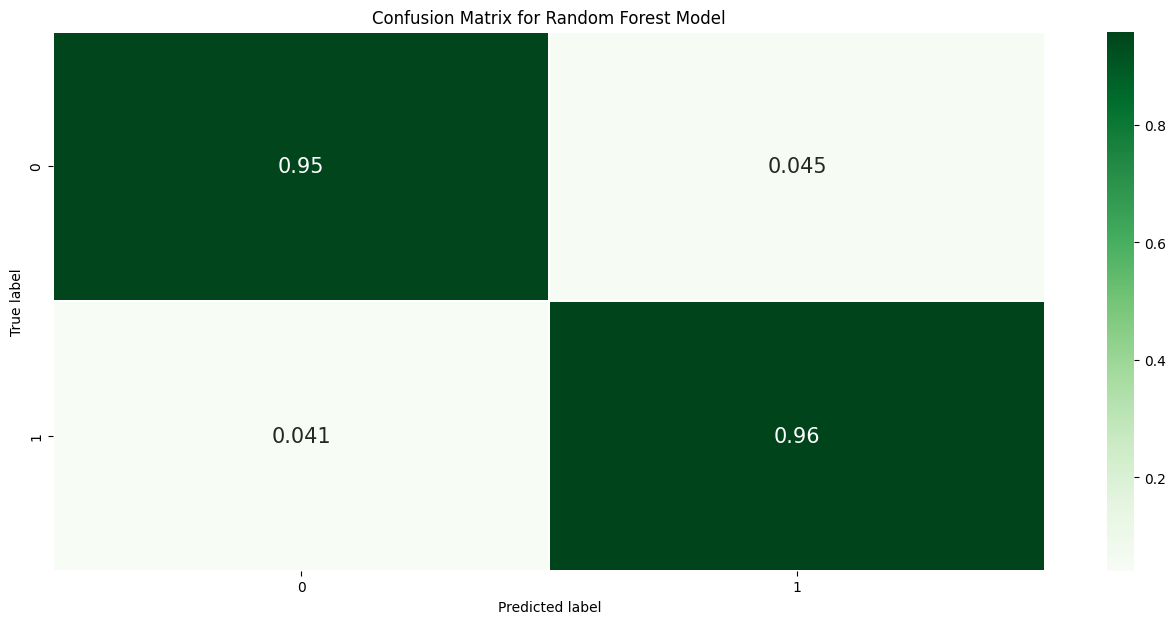

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       577
           1       0.97      0.96      0.96       799

    accuracy                           0.96      1376
   macro avg       0.96      0.96      0.96      1376
weighted avg       0.96      0.96      0.96      1376



array([1.59808488e-02, 1.18635032e-02, 9.43290981e-03, 1.67318098e-02,
       1.26843702e-02, 5.37171174e-03, 5.11637634e-03, 1.15770988e-02,
       3.73362239e-02, 7.12376152e-02, 3.16691261e-02, 1.57074893e-02,
       2.40059531e-01, 1.95005577e-02, 4.73811321e-02, 6.92874270e-02,
       5.03106443e-02, 2.28198910e-02, 1.19987545e-02, 1.77727235e-02,
       1.13111395e-02, 2.13911886e-02, 6.38565801e-04, 1.04953377e-03,
       4.11946886e-02, 9.86591657e-04, 1.19497045e-04, 3.38632321e-05,
       1.17247951e-03, 3.16495288e-03, 1.85634503e-03, 1.82560405e-03,
       1.71415409e-03, 1.23923984e-03, 0.00000000e+00, 4.50351621e-05,
       0.00000000e+00, 0.00000000e+00, 6.76818954e-04, 8.83589034e-06,
       3.96615061e-05, 1.54071226e-04, 0.00000000e+00, 1.51128545e-06,
       4.72847892e-05, 2.58835992e-05, 1.18238144e-05, 9.57403002e-05,
       1.77508379e-04, 4.29276133e-06, 0.00000000e+00, 2.67373804e-03,
       2.25566594e-04, 6.57766695e-07, 1.01205668e-04, 1.12888544e-03,
      

The feature importance for duration_create_to_expire is : 0.015980848809326743
The feature importance for value_in_eth is : 0.011863503158689302
The feature importance for value_in_token is : 0.009432909813557511
The feature importance for value_in_usdt is : 0.016731809770407648
The feature importance for value_in_usdt_now is : 0.012684370183966162
The feature importance for project_length_code is : 0.005371711739554287
The feature importance for experience_level_code is : 0.005116376337934082
The feature importance for github_comments is : 0.011577098799896546
The feature importance for number_of_activities is : 0.03733622386079039
The feature importance for number_of_fulfillments is : 0.07123761523753315
The feature importance for number_of_interests is : 0.03166912610004832
The feature importance for description_length is : 0.015707489258283882
The feature importance for duration_create_to_done is : 0.24005953116109302
The feature importance for duration_create_to_firstAct is : 0.01

,Feature,Feature Importance
12,duration_create_to_done,0.240060
9,number_of_fulfillments,0.071238
15,duration_create_to_submitted,0.069287
16,duration_create_to_killed,0.050311
14,duration_create_to_lastAct,0.047381
148,lastAct_activity_type_work_done,0.044587
138,lastAct_activity_type_killed_bounty,0.044548
24,token_value_in_usdt,0.041195
8,number_of_activities,0.037336
10,number_of_interests,0.031669


In [14]:
#Setting 1 - without bootstrap

# Split dataset into features and target
y = new_raw_data_set1['is_success']
X = new_raw_data_set1.drop(['is_success','pk'], axis = 1).values

# Split features and target into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

# Instantiate and fit the RandomForestClassifier
forest = RandomForestClassifier(criterion='entropy', max_depth=25)
forest.fit(X_train, y_train)

# Make predictions for the test set
y_pred_test = forest.predict(X_test)

# View accuracy score
accuracy_score(y_test, y_pred_test)

# View confusion matrix for test data and predictions
confusion_matrix(y_test, y_pred_test)

# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.heatmap(matrix, annot=True, annot_kws={'size':15},
            cmap=plt.cm.Greens, linewidths=0.2)

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

# View the classification report for test data and predictions
print(classification_report(y_test, y_pred_test))

#-----------------------------------------------------------------------------------------------------------
forest.feature_importances_

#-------------------------------------------------------------------------------------------------------------
# Running Feature Importance

fi_col = []
fi = []

for i,column in enumerate(new_raw_data_set1.drop(['is_success','pk'], axis = 1)):
    
    print('The feature importance for {} is : {}'.format(column, forest.feature_importances_[i]))
    
    fi_col.append(column)
    fi.append(forest.feature_importances_[i])
    
# Creating a Dataframe
fi_df = zip(fi_col, fi)
fi_df = pd.DataFrame(fi_df, columns = ['Feature','Feature Importance'])
fi_df.sort_values('Feature Importance', ascending = False).head(20)

RandomForestClassifier(criterion='entropy', max_depth=25)

0.9854651162790697

array([[574,   4],
       [ 16, 782]])

<Figure size 1600x700 with 0 Axes>

<AxesSubplot: >

Text(0.5, 47.7222222222222, 'Predicted label')

Text(170.72222222222223, 0.5, 'True label')

Text(0.5, 1.0, 'Confusion Matrix for Random Forest Model')

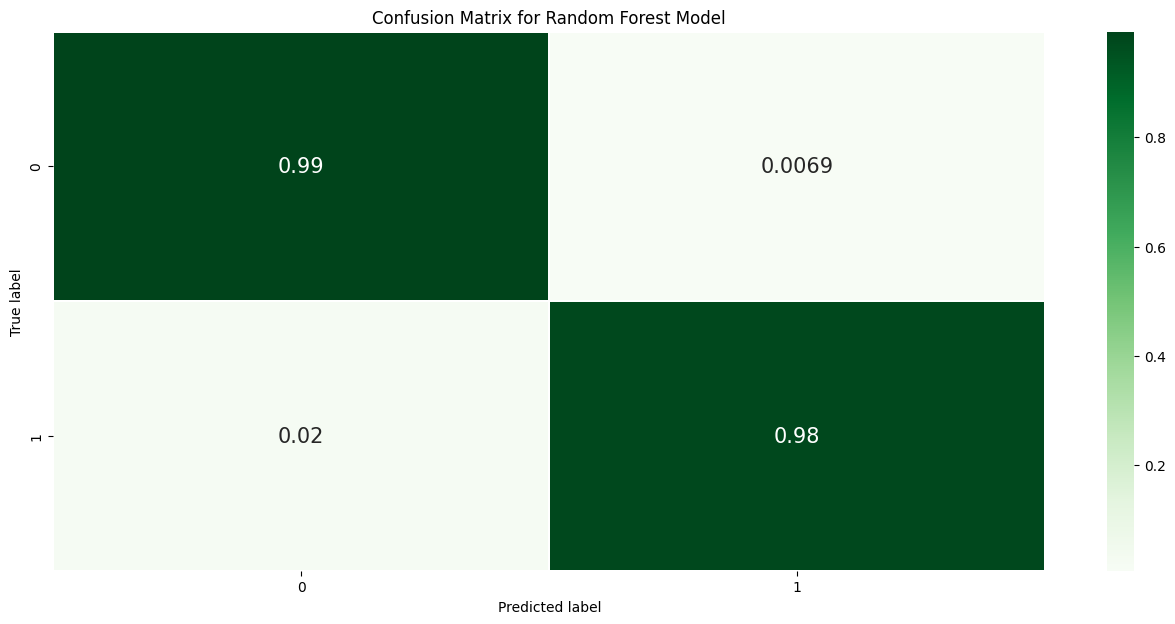

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       578
           1       0.99      0.98      0.99       798

    accuracy                           0.99      1376
   macro avg       0.98      0.99      0.99      1376
weighted avg       0.99      0.99      0.99      1376



array([2.04346351e-02, 1.43841237e-02, 9.73815576e-03, 1.91541190e-02,
       1.50370385e-02, 6.34722271e-03, 6.00474338e-03, 1.39793361e-02,
       3.49520017e-02, 7.68091628e-02, 3.48177898e-02, 1.72669517e-02,
       2.29961544e-01, 1.90759314e-02, 4.72733520e-02, 6.25154668e-02,
       4.42231144e-02, 2.36058507e-02, 1.27350134e-02, 1.56078870e-02,
       1.18834304e-02, 1.87994865e-02, 2.12937325e-04, 7.80070629e-04,
       4.29982508e-02, 1.34714858e-03, 2.04943488e-04, 1.69067925e-04,
       1.14671223e-03, 3.03652148e-03, 2.10508659e-03, 2.15657013e-03,
       1.85541582e-03, 1.09430770e-03, 0.00000000e+00, 2.09128376e-05,
       9.42495652e-06, 0.00000000e+00, 3.75934921e-04, 5.60571391e-05,
       9.70851979e-06, 2.20677207e-04, 4.56163728e-08, 2.48719196e-06,
       0.00000000e+00, 0.00000000e+00, 1.40963141e-05, 2.66430953e-04,
       1.88354173e-04, 3.39774835e-05, 0.00000000e+00, 3.58248070e-03,
       1.26829916e-04, 0.00000000e+00, 1.11806154e-04, 2.14943807e-04,
      

The feature importance for duration_create_to_expire is : 0.020434635095475873
The feature importance for value_in_eth is : 0.014384123679536415
The feature importance for value_in_token is : 0.009738155760570624
The feature importance for value_in_usdt is : 0.01915411902218824
The feature importance for value_in_usdt_now is : 0.01503703848524153
The feature importance for project_length_code is : 0.006347222710258099
The feature importance for experience_level_code is : 0.006004743379378268
The feature importance for github_comments is : 0.01397933610041948
The feature importance for number_of_activities is : 0.03495200166808735
The feature importance for number_of_fulfillments is : 0.0768091627690904
The feature importance for number_of_interests is : 0.03481778983102434
The feature importance for description_length is : 0.017266951677179298
The feature importance for duration_create_to_done is : 0.22996154406288777
The feature importance for duration_create_to_firstAct is : 0.019075

,Feature,Feature Importance
12,duration_create_to_done,0.229962
9,number_of_fulfillments,0.076809
15,duration_create_to_submitted,0.062515
148,lastAct_activity_type_work_done,0.048719
14,duration_create_to_lastAct,0.047273
16,duration_create_to_killed,0.044223
24,token_value_in_usdt,0.042998
138,lastAct_activity_type_killed_bounty,0.037341
8,number_of_activities,0.034952
10,number_of_interests,0.034818


In [15]:
#Setting 1 - with bootstrap

# Split dataset into features and target
y = bootstrapped_set1['is_success']
X = bootstrapped_set1.drop(['is_success','pk'], axis = 1).values

# Split features and target into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

# Instantiate and fit the RandomForestClassifier
forest = RandomForestClassifier(criterion='entropy', max_depth=25)
forest.fit(X_train, y_train)

# Make predictions for the test set
y_pred_test = forest.predict(X_test)

# View accuracy score
accuracy_score(y_test, y_pred_test)

# View confusion matrix for test data and predictions
confusion_matrix(y_test, y_pred_test)

# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.heatmap(matrix, annot=True, annot_kws={'size':15},
            cmap=plt.cm.Greens, linewidths=0.2)

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

# View the classification report for test data and predictions
print(classification_report(y_test, y_pred_test))

#-----------------------------------------------------------------------------------------------------------
forest.feature_importances_

#-------------------------------------------------------------------------------------------------------------
# Running Feature Importance

fi_col = []
fi = []

for i,column in enumerate(bootstrapped_set1.drop(['is_success','pk'], axis = 1)):
    
    print('The feature importance for {} is : {}'.format(column, forest.feature_importances_[i]))
    
    fi_col.append(column)
    fi.append(forest.feature_importances_[i])
    
# Creating a Dataframe
fi_df = zip(fi_col, fi)
fi_df = pd.DataFrame(fi_df, columns = ['Feature','Feature Importance'])
fi_df.sort_values('Feature Importance', ascending = False).head(20)

In [16]:
#Point Biserial

In [17]:
#https://towardsdatascience.com/point-biserial-correlation-with-python-f7cd591bd3b1


import pandas as pd
from scipy.stats import pointbiserialr

# number of features
num_features = 11 # setting 2 
# significance level
alpha = 0.05
# corrected significance level
alpha_corrected = alpha / num_features

# create an empty list to store the results
results = []

for x in bootstrapped_set1.drop(['is_success','pk'], axis = 1):
    pbs = pointbiserialr(bootstrapped_set1['is_success'], bootstrapped_set1[x])
    if pbs.pvalue < alpha_corrected:
        results.append({'feature': x, 'correlation': pbs.correlation, 'pvalue': pbs.pvalue})

# convert the list of dictionaries to a dataframe
df = pd.DataFrame(results)

# write the dataframe to a csv file
df.to_csv('correlation_outcome_3.csv', index=False)

    

/shared-libs/python3.9/py/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c7dbb46d-be11-4d98-a8ae-f659e78e24c4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>